In [1]:
using Revise
using NonEqDigits

In [76]:
using LaTeXStrings
using GLMakie
using CairoMakie
using JLD2
using Geppetto
using DataFrames
using CSV

In [9]:
includet("../scripts/ma_graphviz.jl")

In [10]:
includet("../scripts/ma_colors.jl")
single_col_width = 324 # corresponds to 3+3/8 in as state in PR guidelines
double_col_width = single_col_width*2
golden_ratio = 1.618
nothing

# Spectral gaps

In [71]:
# Calculating them
function make_spectral_gaps_df(L, reduced=false, rs=ca_ucodes_f1();
    zerothreshold=1000*eps(),
)
    sgs = Union{Missing,ComplexF64}[]

    for r in rs
        ma = MolAut(L, r; reduced)
        etm = etransmat(ma; mat=true)

        es = eigen(etm)

        chosenev = missing
        i = 0
        # println("Starting search r=$r")
        while i < length(es.values)
            ev = es.values[end-i]

            # @show abs(ev)
            if abs(ev) > zerothreshold
                chosenev = ev
                # @show ev
                break
            end
            
            i += 1
        end

        # @show es.values[1:3]
        # @show es.values[end-3:end]

        push!(sgs, chosenev)
    end
    
    df = DataFrame(;
        rs,
        sgs
    )
    
    metadata!(df, "L", L)
    metadata!(df, "reduced", reduced)

    df
end

make_spectral_gaps_df (generic function with 3 methods)

### Plot spectral gaps alone

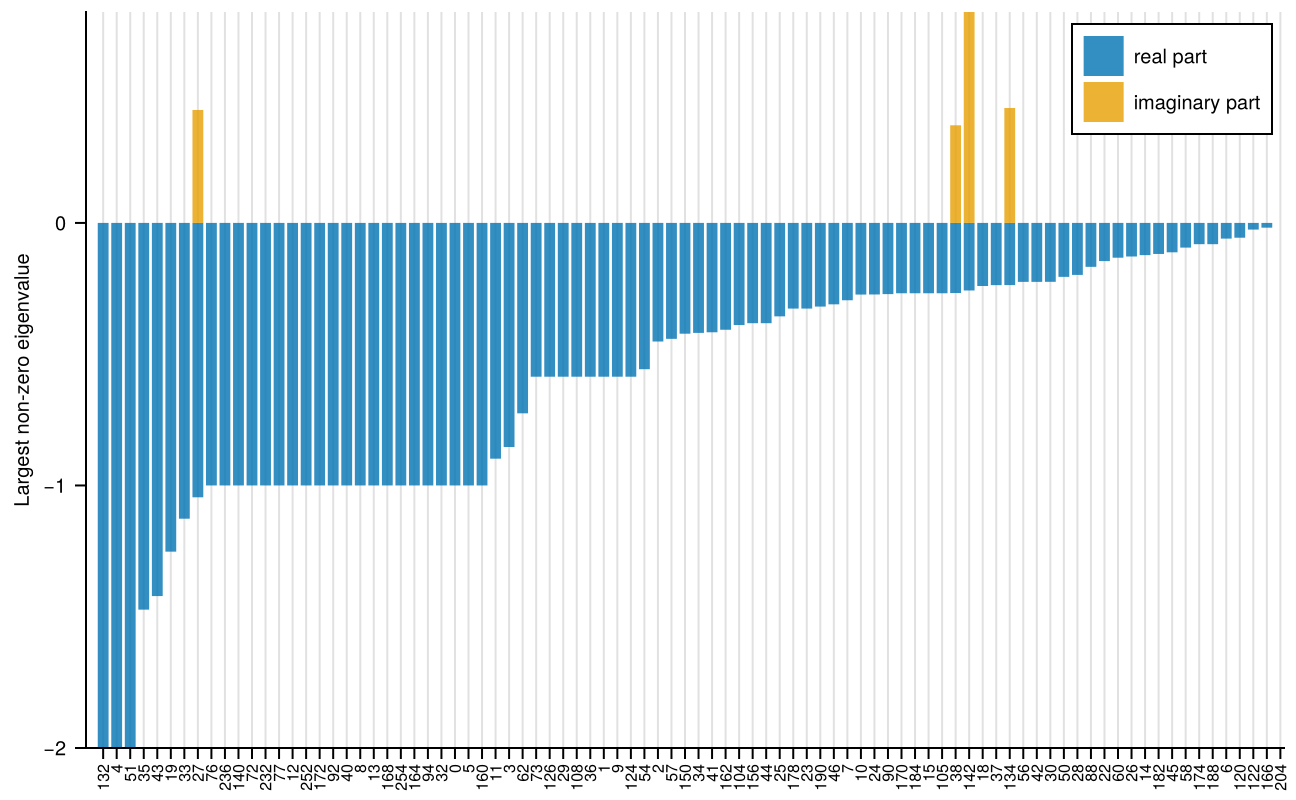

In [127]:
df = make_spectral_gaps_df(6; zerothreshold=1000*eps());
# df = df[sortperm(real(df.sgs)),:]
sort!(df, [order(:sgs; by=c->(real(c), imag(c)))])
pos = 1:length(df.rs)

fig = Figure(;
    size=(double_col_width, double_col_width/golden_ratio),
    fontsize=10,
    figure_padding=6.0
)

################################################################################
# Do Ns plot
################################################################################
ax1 = Axis(fig[1,1];
    # title="L=$L, reduced=$reduced",
    xticks=(pos, string.(df.rs)),
    xticklabelsize=8.,
    xticklabelrotation=pi/2,
    # xgridvisible=false,
    xautolimitmargin = (0.01, 0.01),
    # xlabel="Rule",
    ygridvisible=false,
    yautolimitmargin=(0., 0.),
    # yscale=log2,
    ylabel="Largest non-zero eigenvalue",
)
hidespines!(ax1, :t, :r)

barplot!(ax1, real.(df.sgs);
    label="real part"
)
barplot!(ax1, imag.(df.sgs);
    label="imaginary part"
)

axislegend(ax1)

save("../data/figures/spectral_gaps/p1.pdf", fig)

fig

### Plot based off of numacs

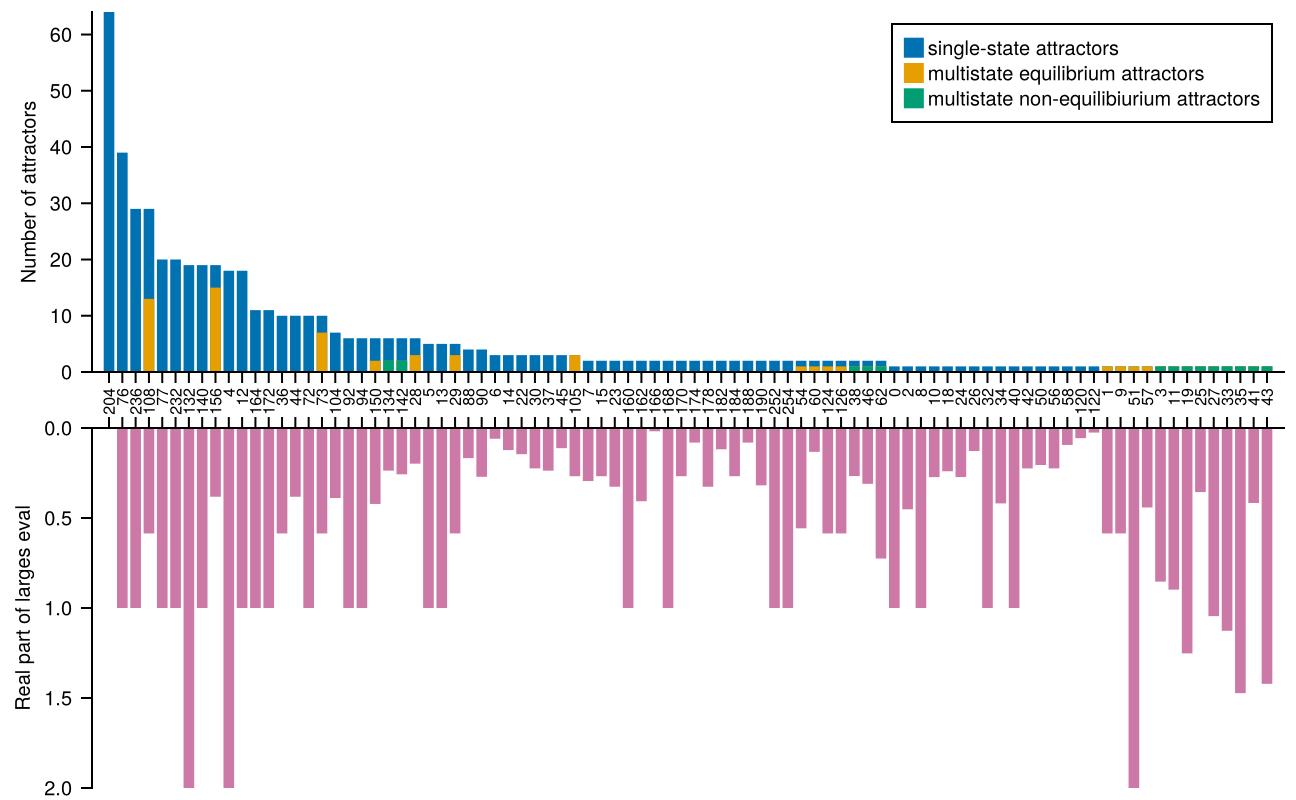

In [126]:
L = 6
# reduced = false

# To get the same sorting
acstats_df = DataFrame(CSV.File("../data/figures/numacs/data/L$(L)f.csv"));
pos = 1:length(acstats_df.rs)

df = make_spectral_gaps_df(L, false, acstats_df.rs)

fig = Figure(;
    size=(double_col_width, double_col_width/golden_ratio),
    fontsize=10,
    figure_padding=6.0
)

################################################################################
# Do Ns plot
################################################################################
ax1 = Axis(fig[1,1];
    # title="L=$L, reduced=$reduced",
    xticks=(pos, string.(acstats_df.rs)),
    xticklabelsize=8.,
    xticklabelrotation=pi/2,
    xgridvisible=false,
    xautolimitmargin = (0.01, 0.01),
    # xlabel="Rule",
    ygridvisible=false,
    yautolimitmargin=(0., 0.),
    # yscale=log2,
    ylabel="Number of attractors",
)
hidespines!(ax1, :t, :r)

# plot data
barplot!(ax1, pos, acstats_df.Nsingle .+ acstats_df.Neq .+ acstats_df.Nneq;
    color=Makie.wong_colors()[1],
    alpha=1.,
    label="single-state attractors",
)
barplot!(ax1, pos, acstats_df.Neq .+ acstats_df.Nneq;
    color=Makie.wong_colors()[2],
    alpha=1.,
    label="multistate equilibrium attractors",
)
barplot!(ax1, pos, acstats_df.Nneq;
    color=Makie.wong_colors()[3],
    alpha=1.,
    label="multistate non-equilibiurium attractors",
)

axislegend(ax1;
    # position=(1., 0.03),
    patchsize=(10., 10.),
    patchlabelgap=2,
    rowgap=1,
)

################################################################################
# Do Ks plot
################################################################################
ax2 = Axis(fig[2,1];
    xaxisposition=:top,
    xticks=(pos, string.(acstats_df.rs)),
    xticklabelsvisible=false,
    xgridvisible=false,
    xautolimitmargin = (0.01, 0.01),
    yreversed=true,
    ygridvisible=false,
    yautolimitmargin=(0., 0.),
    # yscale=log2,
    ylabel="Real part of larges eval",
)
hidespines!(ax2, :b, :r)
linkxaxes!(ax1, ax2)

barplot!(ax2, pos, -real.(df.sgs);
    color=Makie.wong_colors()[4],
)


################################################################################
# Adjust the layout
################################################################################

rowgap!(fig.layout, ax1.xticklabelpad[])

save("../data/figures/spectral_gaps/p2_with_numacs.pdf", fig)
fig

# All rules with just one ssac

# Bits and bobs

In [3]:
GC.gc()
empty!(Out)
GC.gc()